In [1]:
# Intialization
import os
import sys

os.environ["SPARK_HOME"] = "/home/talentum/spark"
os.environ["PYLIB"] = os.environ["SPARK_HOME"] + "/python/lib"
# In below two lines, use /usr/bin/python2.7 if you want to use Python 2
os.environ["PYSPARK_PYTHON"] = "/usr/bin/python3.6" 
os.environ["PYSPARK_DRIVER_PYTHON"] = "/usr/bin/python3"
sys.path.insert(0, os.environ["PYLIB"] +"/py4j-0.10.7-src.zip")
sys.path.insert(0, os.environ["PYLIB"] +"/pyspark.zip")

# NOTE: Whichever package you want mention here.
# os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.databricks:spark-xml_2.11:0.6.0 pyspark-shell' 
# os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.apache.spark:spark-avro_2.11:2.4.0 pyspark-shell'
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.databricks:spark-xml_2.11:0.6.0,org.apache.spark:spark-avro_2.11:2.4.3 pyspark-shell'
# os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.databricks:spark-xml_2.11:0.6.0,org.apache.spark:spark-avro_2.11:2.4.0 pyspark-shell'

In [2]:
#Entrypoint 2.x
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("My work").enableHiveSupport().getOrCreate()

# On yarn:
# spark = SparkSession.builder.appName("Spark SQL basic example").enableHiveSupport().master("yarn").getOrCreate()
# specify .master("yarn")

sc = spark.sparkContext

In [3]:
#-------------------------------------------------------------------------------------------------------------------------------
import pandas as pd
from pyspark import SparkContext                                    # Importing SparkContext
from pyspark.sql import SparkSession, Window, Row                   # Importing importing methods for creating a cluster
from pyspark.sql import functions as F                              # Importing SQL Functions
from pyspark.sql.functions import col, isnan, when, count           # Importing relevant dataframe functions
from pyspark.sql.functions import *                                 # Importing inbuilt SQL Functions
from pyspark.sql.types import *                                     # Importing SQL types
#-------------------------------------------------------------------------------------------------------------------------------
import matplotlib.pyplot as plt                                     # Popular plotting library
% matplotlib inline                                                  # To plot graphs inline the notebook
import seaborn as sns                                               # Advanced plotting library
from handyspark import *                                            # Helper library to plot graphs
#-------------------------------------------------------------------------------------------------------------------------------
from pyspark.ml.feature import VectorAssembler                      # For processing dataset for ML
#-------------------------------------------------------------------------------------------------------------------------------
import warnings                                                     # Importing warning to disable runtime warnings
warnings.filterwarnings("ignore")                                   # Warnings will appear only once
#-------------------------------------------------------------------------------------------------------------------------------

UsageError: Line magic function `%` not found.


In [5]:
filepath = "file:///home/talentum/shared/state3.csv"
df = spark.read.csv(filepath, header=True, inferSchema=True)

In [6]:
from pyspark.sql.functions import to_timestamp

# assume 'df' is your PySpark DataFrame and 'source' is your column name
df = df.withColumn("from_date", to_timestamp(df["from_date"], "dd-MM-yyyy"))
df= df.withColumn("to_date", to_timestamp(df["to_date"], "dd-MM-yyyy"))

In [7]:
columns_to_cast = [c for c in df.columns if c not in ['state','from_date','to_date']]
for c in columns_to_cast:
    df = df.withColumn(c, col(c).cast("double"))    

In [8]:
numerical_columns_new = [col[0] for col in df.dtypes if col[1] in ("IntegerType", "double")]
string_columns_new = [col[0] for col in df.dtypes if col[1] == "string"]

print("All Numerial columns:")
print(numerical_columns_new)
print("\n")
print("All string columns:")
print(string_columns_new)

All Numerial columns:
['bp_mmhg', 'benzene_ug_m3', 'mp_xylene_ug_m3', 'o_xylene_ug_m3', 'xylene_ug_m3', 'co_mg_m3', 'nh3_ug_m3', 'so2_ug_m3', 'at_degree', 'rf_mm', 'temp_degree_c', 'eth_benzene_ug_m3', 'temp_', 'at_degree_c', 'wd_degree', 'wd_deg', 'nox_ppb', 'no_ug_m3', 'toluene_ug_m3', 'rh_degree', 'nox_ug_m3', 'ozone_ug_m3', 'pm10_ug_m3', 'sr_w_mt2', 'vws_m_s', 'ws_m_s', 'no2_ug_m3', 'pm2_5_ug_m3', 'rh_%']


All string columns:
['state']


In [9]:
df1=df

In [10]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, isnan, when, count, lit

# Initialize Spark session (if not already initialized)
spark = SparkSession.builder.appName("NullPercentage").getOrCreate()

# Create a DataFrame (assuming it's already loaded as 'df')

# Define a function to calculate null percentages for numeric and non-numeric columns
def calculate_null_percentage(df):
    total_count = df.count()
    exprs = []

    for c in df.columns:
        if dict(df.dtypes)[c] in ['double', 'float', 'int']:
            exprs.append((count(when(col(c).isNull() | isnan(c), c)) / total_count).alias(c))
        else:
            exprs.append((count(when(col(c).isNull(), c)) / total_count).alias(c))

    return df.select(exprs)

# Calculate the null percentage for each column
null_percentage_df = calculate_null_percentage(df1)

# Show the null percentages
null_percentage_df.toPandas().transpose()


,0
bp_mmhg,0.581224
benzene_ug_m3,0.000000
mp_xylene_ug_m3,0.000000
o_xylene_ug_m3,1.000000
xylene_ug_m3,1.000000
co_mg_m3,0.000000
nh3_ug_m3,0.000000
so2_ug_m3,0.000000
at_degree,1.000000
rf_mm,0.806752


In [11]:
# Convert the null percentage DataFrame to a dictionary for easy access
null_percentages = null_percentage_df.collect()[0].asDict()

# Define the threshold for dropping columns (50% in this case)
threshold = 0.50

# Select the columns to keep (those with null percentage <= 50%)
columns_to_keep = [col for col, pct in null_percentages.items() if pct <= threshold]
print("Columns to keep:")
print(columns_to_keep)

# Create a new DataFrame with the selected columns
df_filtered = df.select(columns_to_keep)

# Show the new DataFrame
#df_filtered.show(truncate=False)
df_filtered.toPandas()

Columns to keep:
['benzene_ug_m3', 'mp_xylene_ug_m3', 'co_mg_m3', 'nh3_ug_m3', 'so2_ug_m3', 'from_date', 'eth_benzene_ug_m3', 'state', 'at_degree_c', 'wd_degree', 'no_ug_m3', 'toluene_ug_m3', 'rh_degree', 'nox_ug_m3', 'to_date', 'ozone_ug_m3', 'pm10_ug_m3', 'ws_m_s', 'no2_ug_m3', 'pm2_5_ug_m3']


,benzene_ug_m3,mp_xylene_ug_m3,co_mg_m3,nh3_ug_m3,so2_ug_m3,from_date,eth_benzene_ug_m3,state,at_degree_c,wd_degree,no_ug_m3,toluene_ug_m3,rh_degree,nox_ug_m3,to_date,ozone_ug_m3,pm10_ug_m3,ws_m_s,no2_ug_m3,pm2_5_ug_m3
0,0.01,0.10,0.44,17.88,5.03,2020-03-21 02:00:00,0.08,Mizoram,NaN,272.75,2.83,NaN,NaN,NaN,2020-03-21 03:00:00,5.88,65.14,0.95,0.13,7.00
1,0.14,0.49,0.32,24.02,6.85,2020-03-24 17:00:00,0.28,Mizoram,NaN,242.77,3.05,NaN,NaN,NaN,2020-03-24 18:00:00,6.34,51.53,0.70,0.26,7.00
2,0.01,0.68,0.49,18.43,5.80,2020-03-24 23:00:00,0.39,Mizoram,NaN,262.43,2.89,NaN,NaN,NaN,2020-03-25 00:00:00,5.28,91.00,0.83,0.09,7.00
3,0.19,0.51,0.32,24.60,7.07,2020-03-28 09:00:00,0.30,Mizoram,NaN,240.70,2.86,NaN,NaN,NaN,2020-03-28 10:00:00,8.40,41.66,1.73,0.08,26.16
4,0.11,0.49,0.32,27.36,5.20,2020-04-13 11:00:00,0.25,Mizoram,NaN,184.42,5.06,NaN,NaN,NaN,2020-04-13 12:00:00,3.50,33.00,2.38,0.96,27.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110806,1.53,1.26,1.51,16.69,3.00,2022-12-04 22:00:00,1.10,Odisha,25.55,7.88,10.30,0.63,71.37,70.85,2022-12-04 23:00:00,9.34,117.11,0.10,45.63,72.75
110807,0.97,1.02,1.47,16.69,3.00,2022-12-05 05:00:00,0.84,Odisha,25.55,7.88,10.30,0.63,71.37,19.73,2022-12-05 06:00:00,9.10,166.86,0.09,53.48,102.19
110808,0.79,0.86,1.08,16.69,3.94,2022-12-06 16:00:00,0.77,Odisha,25.55,38.28,10.30,0.63,71.37,19.73,2022-12-06 17:00:00,10.30,85.96,0.31,55.73,54.79
110809,1.47,1.10,1.19,16.69,2.92,2022-12-12 19:00:00,0.65,Odisha,25.55,8.33,10.30,0.63,71.37,19.73,2022-12-12 20:00:00,9.42,104.45,0.13,15.08,55.69


## Imputing null values

In [12]:
from pyspark.sql.types import IntegerType, FloatType, DoubleType
from pyspark.ml.feature import Imputer

numeric_column_names = [column.name for column in df_filtered.schema.fields
                        if isinstance(column.dataType, (IntegerType, FloatType, DoubleType))]


# Initialize the Imputer
imputer = Imputer(
    inputCols= numeric_column_names, #specifying the input column names
    outputCols=numeric_column_names, #specifying the output column names
    strategy="median"                  # or "median" if you want to use the median value
)

# Fit the Imputer
model = imputer.fit(df_filtered)

#Transform the dataset
imputed_df = model.transform(df_filtered)


In [13]:
# Check: After Imputing percentage of null values
new_df=calculate_null_percentage(imputed_df)
new_df.toPandas().transpose()

,0
benzene_ug_m3,0.0
mp_xylene_ug_m3,0.0
co_mg_m3,0.0
nh3_ug_m3,0.0
so2_ug_m3,0.0
from_date,0.0
eth_benzene_ug_m3,0.0
state,0.0
at_degree_c,0.0
wd_degree,0.0


In [14]:
pdf = imputed_df

In [15]:
from pyspark.sql import functions as F
from pyspark.sql import DataFrame

def calculate_aqi(df: DataFrame) -> DataFrame:
    return df.withColumn(
        "AQI_Category",
        F.when(
            (F.col("pm2_5_ug_m3") <= 30) & (F.col("pm10_ug_m3") <= 50) & (F.col("so2_ug_m3") <= 40) & (F.col("no2_ug_m3") <= 40),
            "Good"
        ).when(
            (F.col("pm2_5_ug_m3") <= 60) & (F.col("pm10_ug_m3") <= 100) & (F.col("so2_ug_m3") <= 80) & (F.col("no2_ug_m3") <= 80),
            "Moderate"
        ).when(
            (F.col("pm2_5_ug_m3") <= 90) & (F.col("pm10_ug_m3") <= 250) & (F.col("so2_ug_m3") <= 380) & (F.col("no2_ug_m3") <= 180),
            "Unhealthy"
        ).when(
            (F.col("pm2_5_ug_m3") > 120) | (F.col("pm10_ug_m3") > 350) | (F.col("so2_ug_m3") > 800) & (F.col("no2_ug_m3") <= 280),
            "Very Unhealthy"
        ).otherwise("Hazardous")
    )

# Load your DataFrame (assuming 'df' is your existing DataFrame)
df_with_aqi = calculate_aqi(pdf)

# Show the result
#df_with_aqi.show(truncate=False)


In [16]:
df_with_aqi.limit(5).toPandas()

,benzene_ug_m3,mp_xylene_ug_m3,co_mg_m3,nh3_ug_m3,so2_ug_m3,from_date,eth_benzene_ug_m3,state,at_degree_c,wd_degree,...,toluene_ug_m3,rh_degree,nox_ug_m3,to_date,ozone_ug_m3,pm10_ug_m3,ws_m_s,no2_ug_m3,pm2_5_ug_m3,AQI_Category
0,0.01,0.10,0.44,17.88,5.03,2020-03-21 02:00:00,0.08,Mizoram,25.55,272.75,...,0.63,71.37,19.73,2020-03-21 03:00:00,5.88,65.14,0.95,0.13,7.00,Moderate
1,0.14,0.49,0.32,24.02,6.85,2020-03-24 17:00:00,0.28,Mizoram,25.55,242.77,...,0.63,71.37,19.73,2020-03-24 18:00:00,6.34,51.53,0.70,0.26,7.00,Moderate
2,0.01,0.68,0.49,18.43,5.80,2020-03-24 23:00:00,0.39,Mizoram,25.55,262.43,...,0.63,71.37,19.73,2020-03-25 00:00:00,5.28,91.00,0.83,0.09,7.00,Moderate
3,0.19,0.51,0.32,24.60,7.07,2020-03-28 09:00:00,0.30,Mizoram,25.55,240.70,...,0.63,71.37,19.73,2020-03-28 10:00:00,8.40,41.66,1.73,0.08,26.16,Good
4,0.11,0.49,0.32,27.36,5.20,2020-04-13 11:00:00,0.25,Mizoram,25.55,184.42,...,0.63,71.37,19.73,2020-04-13 12:00:00,3.50,33.00,2.38,0.96,27.11,Good


In [17]:
df_with_aqi.printSchema()

root
 |-- benzene_ug_m3: double (nullable = true)
 |-- mp_xylene_ug_m3: double (nullable = true)
 |-- co_mg_m3: double (nullable = true)
 |-- nh3_ug_m3: double (nullable = true)
 |-- so2_ug_m3: double (nullable = true)
 |-- from_date: timestamp (nullable = true)
 |-- eth_benzene_ug_m3: double (nullable = true)
 |-- state: string (nullable = true)
 |-- at_degree_c: double (nullable = true)
 |-- wd_degree: double (nullable = true)
 |-- no_ug_m3: double (nullable = true)
 |-- toluene_ug_m3: double (nullable = true)
 |-- rh_degree: double (nullable = true)
 |-- nox_ug_m3: double (nullable = true)
 |-- to_date: timestamp (nullable = true)
 |-- ozone_ug_m3: double (nullable = true)
 |-- pm10_ug_m3: double (nullable = true)
 |-- ws_m_s: double (nullable = true)
 |-- no2_ug_m3: double (nullable = true)
 |-- pm2_5_ug_m3: double (nullable = true)
 |-- AQI_Category: string (nullable = false)



# Finding insights

In [18]:
# Display basic statistics
df_with_aqi.describe().toPandas()

,summary,benzene_ug_m3,mp_xylene_ug_m3,co_mg_m3,nh3_ug_m3,so2_ug_m3,eth_benzene_ug_m3,state,at_degree_c,wd_degree,no_ug_m3,toluene_ug_m3,rh_degree,nox_ug_m3,ozone_ug_m3,pm10_ug_m3,ws_m_s,no2_ug_m3,pm2_5_ug_m3,AQI_Category
0,count,110811,110811,110811,110811,110811,110811,110811,110811,110811,110811,110811,110811,110811,110811,110811,110811,110811,110811,110811
1,mean,0.17670366660349668,8.258436166087002,0.8409053252835955,15.71016153630459,15.9437266155849,30.34732688993555,None,24.03567200005938,171.94537383461267,9.250637301353452,1.210448962648906,69.59733970460313,21.72408181497561,14.209406647354466,82.87442690706173,1.7840454467524807,10.65575746090131,38.48784741587671,None
2,stddev,0.5004936922692099,10.474828441851939,0.7870786022295355,15.877884671391666,11.135066676042923,68.11447652159036,None,4.464832076050161,55.81424550847446,9.513143083231075,2.6083274726059207,12.857433351615152,12.353986721716625,14.89961941900584,61.855597956402875,0.9266027074475086,11.702237088178896,32.552160236351426,None
3,min,0.0,0.01,0.0,0.01,0.0,0.01,Mizoram,0.55,0.1,0.01,0.0,2.42,0.0,0.01,0.01,0.01,0.01,0.01,Good
4,max,3.22,63.71,3.73,87.38,54.55,328.37,Odisha,43.12,358.1,50.96,23.0,99.95,74.8,80.69,317.07,6.46,57.09,161.02,Very Unhealthy


## Step 1: Distribution of Each Column

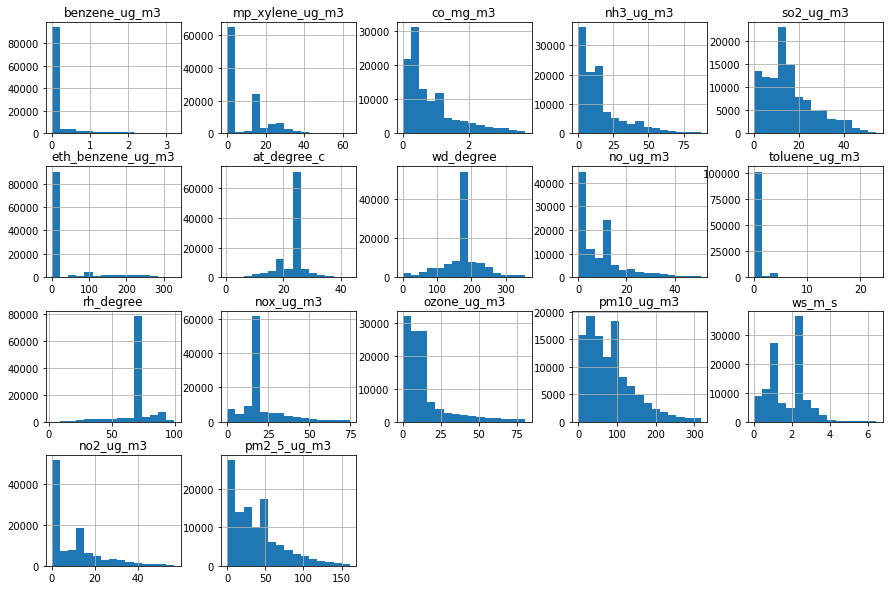

In [19]:
#import matplotlib.pyplot as plt
#import pandas as pd

# Convert to Pandas DataFrame for easy visualization
pandas_df = df_with_aqi.toPandas()

# Plot histograms for each numeric column
numeric_columns = [col for col in pandas_df.columns if pandas_df[col].dtype != 'object']

pandas_df[numeric_columns].hist(bins=15, figsize=(15, 10), layout=(4, 5))
plt.show()


### 1.2 Identify Correlations

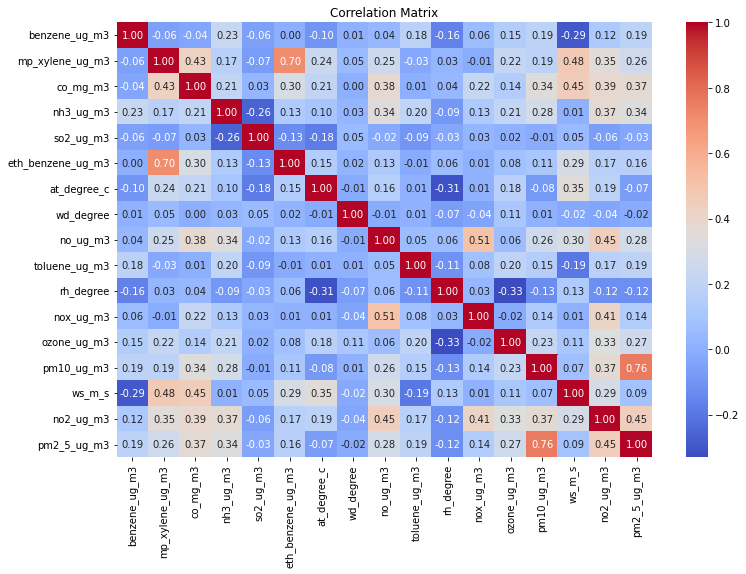

In [20]:
import seaborn as sns

# Calculate the correlation matrix
corr_matrix = pandas_df[numeric_columns].corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


## Step 2: Data Visualization

### 2.1 Scatter Plots to Explore Relationships

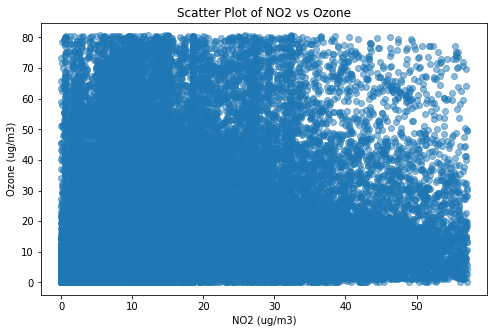

In [21]:
# Example: Scatter plot between 'no2_ug_m3' and 'ozone_ug_m3'
plt.figure(figsize=(8, 5))
plt.scatter(pandas_df['no2_ug_m3'], pandas_df['ozone_ug_m3'], alpha=0.5)
plt.title('Scatter Plot of NO2 vs Ozone')
plt.xlabel('NO2 (ug/m3)')
plt.ylabel('Ozone (ug/m3)')
plt.show()


### 2.2 Pair Plot to Explore Multiple Relationships

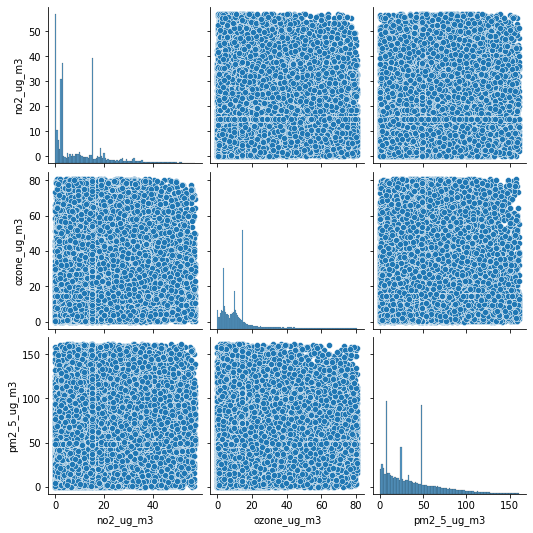

In [22]:
# Plot pair plot for a subset of features
sns.pairplot(pandas_df[['no2_ug_m3', 'ozone_ug_m3', 'pm2_5_ug_m3', 'AQI_Category']])
plt.show()

### 2.3 Categorical Analysis (e.g., AQI_Category Distribution)

+--------------+-----+
|  AQI_Category|count|
+--------------+-----+
|      Moderate|40348|
|          Good|34253|
|     Unhealthy|25690|
|     Hazardous| 7373|
|Very Unhealthy| 3147|
+--------------+-----+



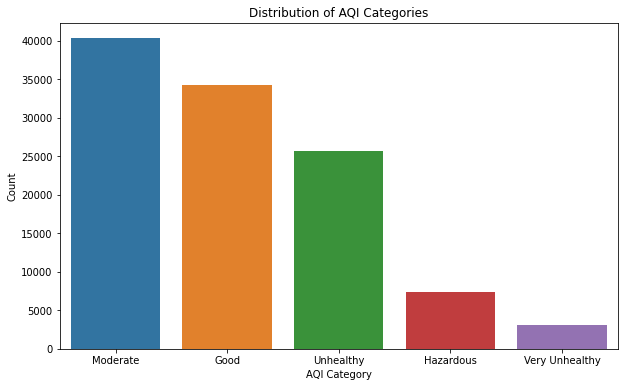

In [23]:
# Count the occurrences of each category
category_counts = df_with_aqi.groupBy("AQI_Category").count().orderBy("count", ascending=False)
category_counts.show()

# Convert to Pandas for plotting
category_counts_pd = category_counts.toPandas()

# Bar plot of AQI_Category distribution
plt.figure(figsize=(10, 6))
sns.barplot(x='AQI_Category', y='count', data=category_counts_pd)
plt.title('Distribution of AQI Categories')
plt.xlabel('AQI Category')
plt.ylabel('Count')
plt.show()


## Step 3: Time-Series Visualization

### 5.1 Plotting Time-Series Trends

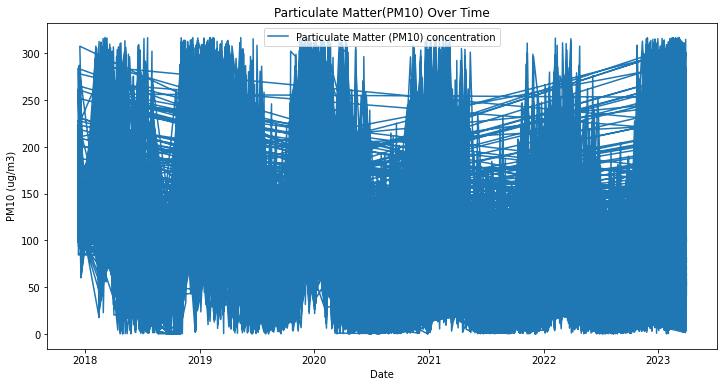

In [24]:
# Convert from_date and to_date to Pandas datetime format for easier manipulation
pandas_df['from_date'] = pd.to_datetime(pandas_df['from_date'])
pandas_df['to_date'] = pd.to_datetime(pandas_df['to_date'])

# Plot time-series for ozone concentration
plt.figure(figsize=(12, 6))
plt.plot(pandas_df['from_date'], pandas_df['pm10_ug_m3'], label='Particulate Matter (PM10) concentration')
plt.xlabel('Date')
plt.ylabel('PM10 (ug/m3)')
plt.title('Particulate Matter(PM10) Over Time')
plt.legend()
plt.show()


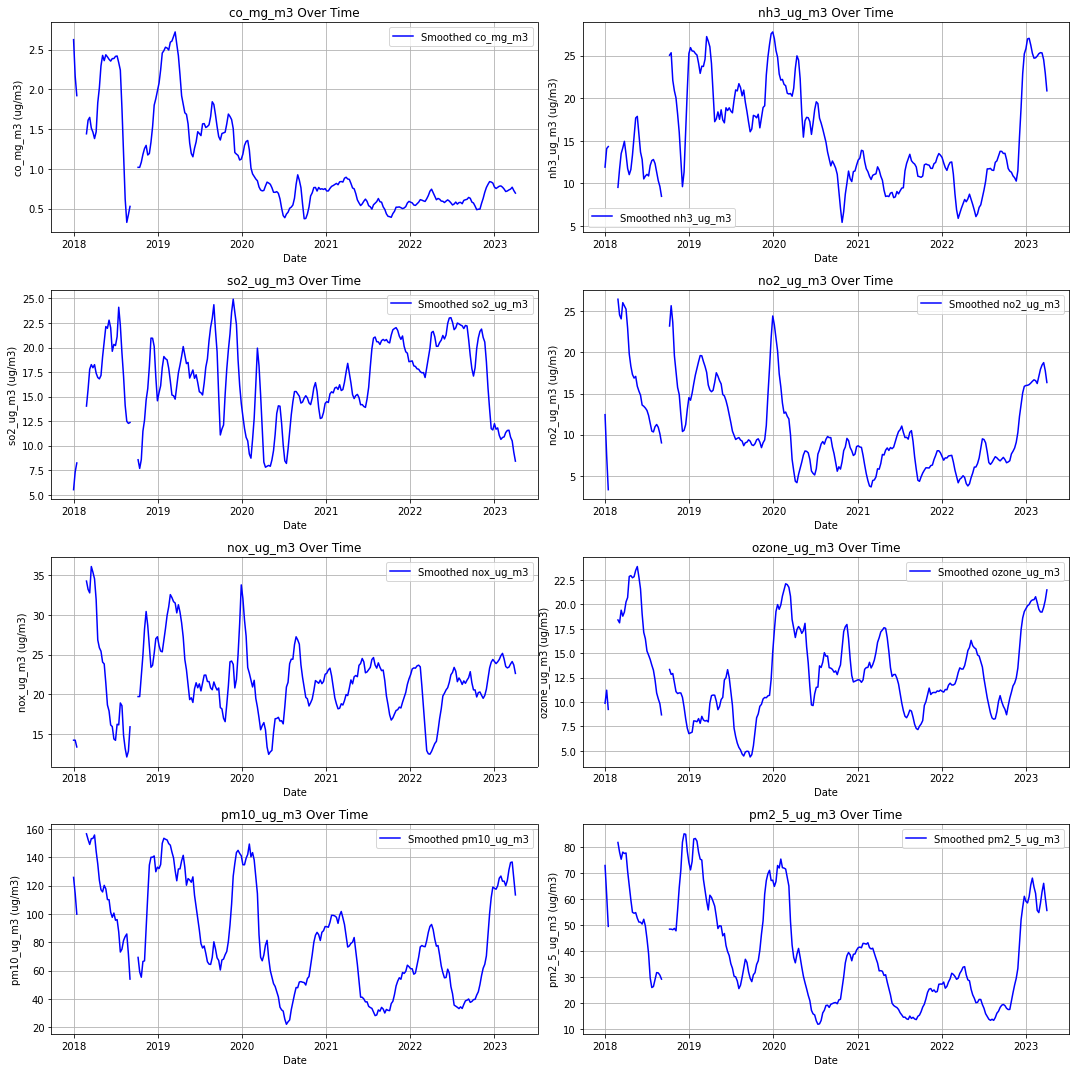

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert 'from_date' and 'to_date' to datetime if not already done
pandas_df['from_date'] = pd.to_datetime(pandas_df['from_date'])
pandas_df['to_date'] = pd.to_datetime(pandas_df['to_date'])

# List of columns to plot
columns_to_plot = ['co_mg_m3', 'nh3_ug_m3', 'so2_ug_m3', 'no2_ug_m3','nox_ug_m3', 'ozone_ug_m3', 'pm10_ug_m3', 'pm2_5_ug_m3']

# Resample the data to a weekly mean to reduce noise
pandas_df_resampled = pandas_df.resample('W', on='from_date').mean()

# Apply a rolling mean to smooth the data further (optional)
for col in columns_to_plot:
    pandas_df_resampled[col + '_smoothed'] = pandas_df_resampled[col].rolling(window=4).mean()

# Set up the subplots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 15))
axes = axes.flatten()

# Plot each time series on a different subplot
for i, col in enumerate(columns_to_plot):
    ax = axes[i]
    ax.plot(pandas_df_resampled.index, pandas_df_resampled[col + '_smoothed'], label=f'Smoothed {col}', color='blue')
    ax.set_xlabel('Date')
    ax.set_ylabel(f'{col} (ug/m3)')
    ax.set_title(f'{col} Over Time')
    ax.grid(True)
    ax.legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


## Step 4. Augmented Dickey-Fuller (ADF) Test

### 4.1 Perform ADF Test for Stationarity

In [26]:
from statsmodels.tsa.stattools import adfuller

# Function to perform ADF test and print the results
def adf_test(timeseries):
    adf_result = adfuller(timeseries.dropna())
    print('ADF Statistic: %f' % adf_result[0])
    print('p-value: %f' % adf_result[1])
    for key, value in adf_result[4].items():
        print('Critical Values:')
        print(f'   {key}, {value}')

# Example usage on one column, say 'ozone_ug_m3'
adf_test(pandas_df['ozone_ug_m3'])


ADF Statistic: -20.520567
p-value: 0.000000
Critical Values:
   1%, -3.430409052298959
Critical Values:
   5%, -2.8615661002188637
Critical Values:
   10%, -2.566783892228334


### 4.2. Plot Rolling Statistics
You can also visually inspect the time series to see if it looks stationary. One common method is to plot the rolling mean and standard deviation.

### Plot Rolling Mean and Standard Deviation

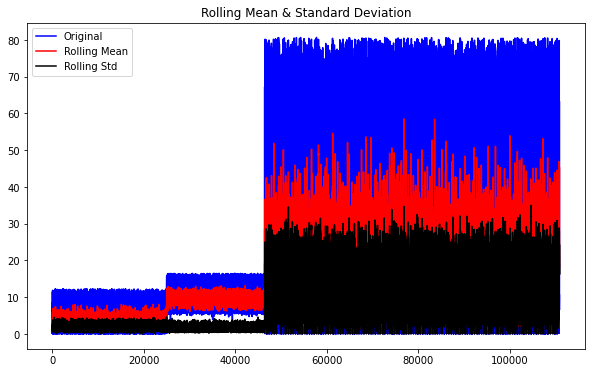

In [27]:
# Plot rolling statistics
def plot_rolling_statistics(timeseries, window=12):
    plt.figure(figsize=(10, 6))
    # Determine rolling statistics
    rolling_mean = timeseries.rolling(window=window).mean()
    rolling_std = timeseries.rolling(window=window).std()
    
    # Plot original time series, rolling mean, and rolling std
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(rolling_mean, color='red', label='Rolling Mean')
    plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

# Example usage on one column, say 'ozone_ug_m3'
plot_rolling_statistics(pandas_df['ozone_ug_m3'])



Results for co_mg_m3:


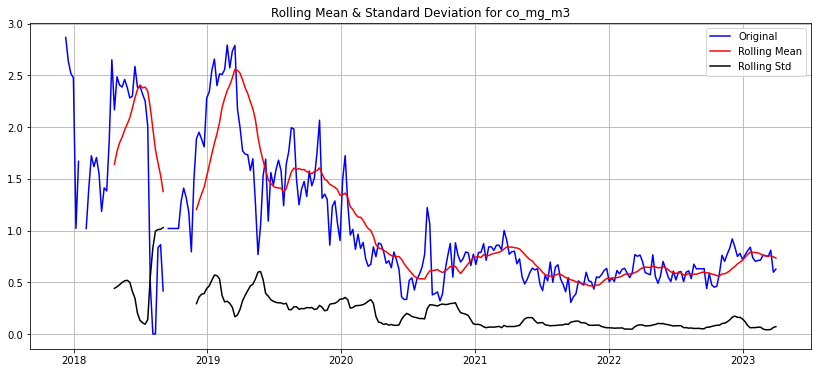

ADF Statistic for co_mg_m3: -3.324415493149934
p-value for co_mg_m3: 0.013821757397654002
Critical Values:
   1%: -3.4546223782586534
   5%: -2.8722253212300277
   10%: -2.5724638500216264

Results for nh3_ug_m3:


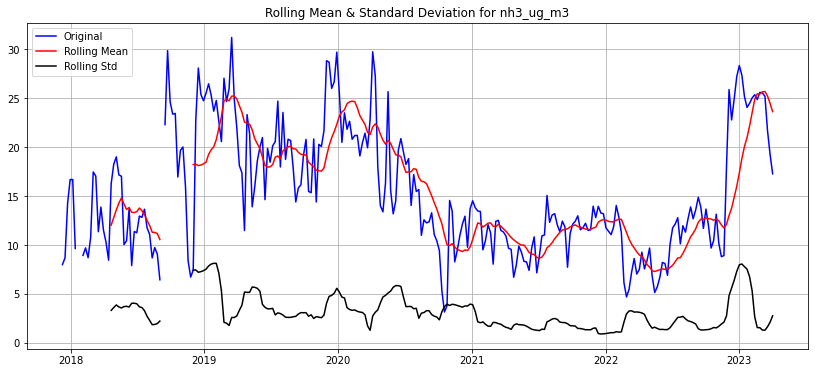

ADF Statistic for nh3_ug_m3: -2.546651185597022
p-value for nh3_ug_m3: 0.10453212190724959
Critical Values:
   1%: -3.4550813975770827
   5%: -2.8724265892710914
   10%: -2.5725712007462582

Results for so2_ug_m3:


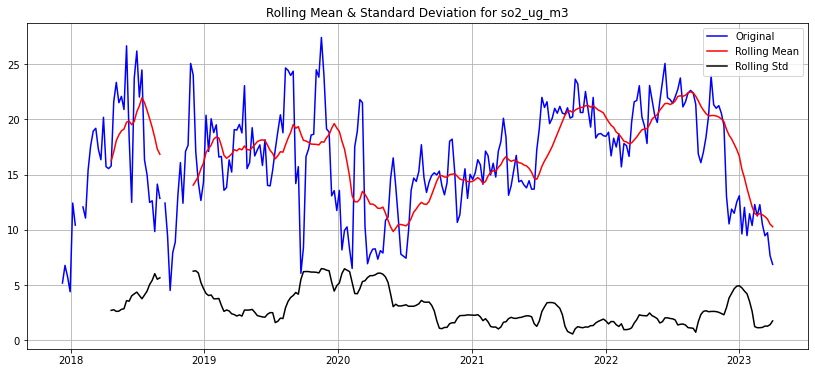

ADF Statistic for so2_ug_m3: -5.360626936109165
p-value for so2_ug_m3: 4.095588134994692e-06
Critical Values:
   1%: -3.4544435065994437
   5%: -2.8721468827772774
   10%: -2.572422013959188

Results for no2_ug_m3:


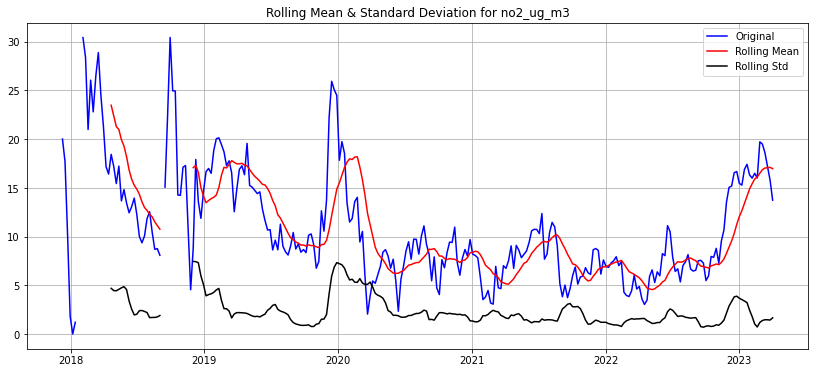

ADF Statistic for no2_ug_m3: -4.9577283649201265
p-value for no2_ug_m3: 2.6889977612334245e-05
Critical Values:
   1%: -3.45453261164607
   5%: -2.8721859575020017
   10%: -2.572442854861866

Results for ozone_ug_m3:


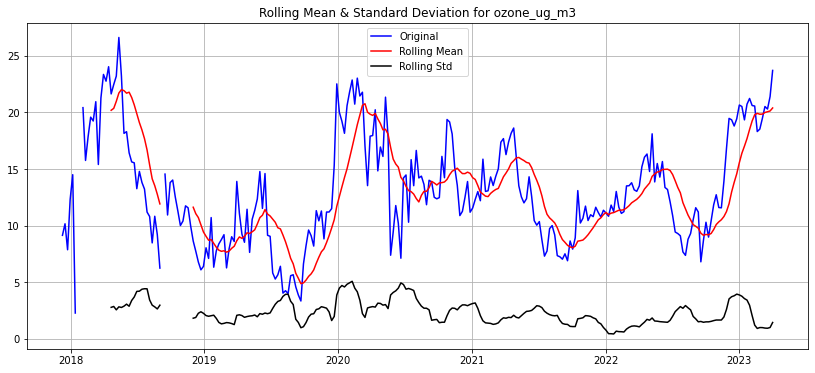

ADF Statistic for ozone_ug_m3: -2.9637732657047366
p-value for ozone_ug_m3: 0.038418828443501474
Critical Values:
   1%: -3.45453261164607
   5%: -2.8721859575020017
   10%: -2.572442854861866

Results for pm10_ug_m3:


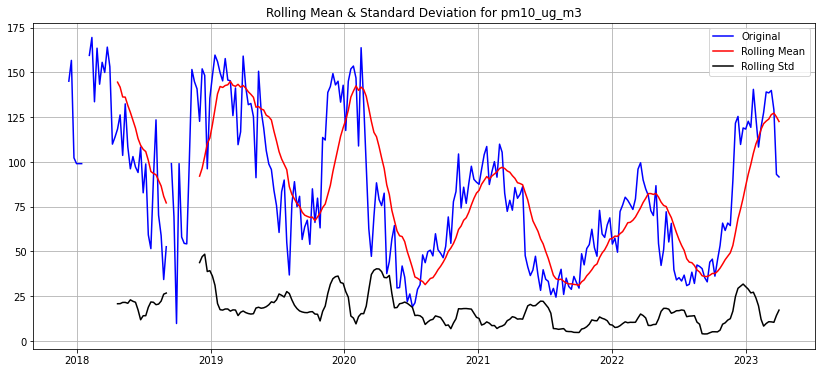

ADF Statistic for pm10_ug_m3: -4.306236103446316
p-value for pm10_ug_m3: 0.00043329548184128464
Critical Values:
   1%: -3.4556556713934934
   5%: -2.872678352489859
   10%: -2.57270548832225

Results for pm2_5_ug_m3:


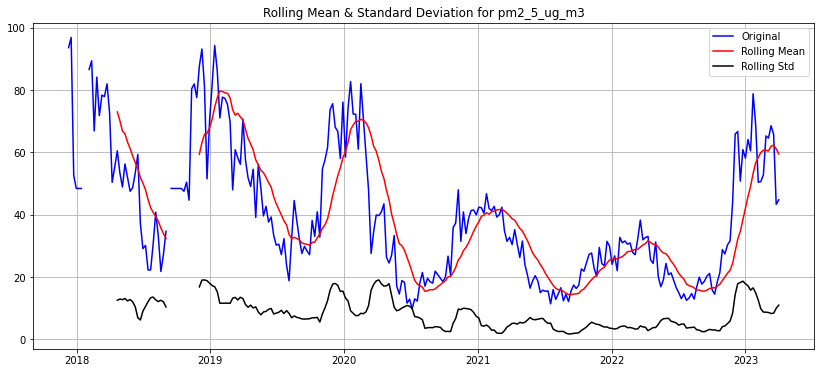

ADF Statistic for pm2_5_ug_m3: -3.1948788668674966
p-value for pm2_5_ug_m3: 0.020283030784125473
Critical Values:
   1%: -3.455175292841607
   5%: -2.8724677563219485
   10%: -2.57259315846006


In [28]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

# Convert 'from_date' to datetime if not already done
pandas_df['from_date'] = pd.to_datetime(pandas_df['from_date'])

# Resample to reduce noise (e.g., weekly)
pandas_df_resampled = pandas_df.resample('W', on='from_date').mean()

# Function to perform ADF test and plot rolling statistics
def plot_stationarity_check(timeseries, column_name, window=12):
    # Rolling statistics
    rolling_mean = timeseries.rolling(window=window).mean()
    rolling_std = timeseries.rolling(window=window).std()
    
    # Plotting
    plt.figure(figsize=(14, 6))
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(rolling_mean, color='red', label='Rolling Mean')
    plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title(f'Rolling Mean & Standard Deviation for {column_name}')
    plt.grid(True)
    plt.show()
    
    # ADF test
    adf_result = adfuller(timeseries.dropna())
    print(f'ADF Statistic for {column_name}: {adf_result[0]}')
    print(f'p-value for {column_name}: {adf_result[1]}')
    print('Critical Values:')
    for key, value in adf_result[4].items():
        print(f'   {key}: {value}')

# List of columns to check
columns_to_check = ['co_mg_m3', 'nh3_ug_m3', 'so2_ug_m3', 'no2_ug_m3', 'ozone_ug_m3', 'pm10_ug_m3', 'pm2_5_ug_m3']

# Iterate through the columns and plot/check each
for col in columns_to_check:
    print(f"\nResults for {col}:")
    plot_stationarity_check(pandas_df_resampled[col], col)


In [29]:
from pyspark.sql.functions import year, month, weekofyear, col, avg, count

# Convert 'from_date' to year, month, and week columns
df = df_with_aqi.withColumn("year", year(col("from_date"))) \
        .withColumn("month", month(col("from_date"))) \
        .withColumn("week", weekofyear(col("from_date")))

# Example 1: Year-wise Analysis
yearly_summary = df.groupBy("year").agg(
    avg("pm10_ug_m3").alias("avg_pm10"),
    avg("co_mg_m3").alias("avg_co"),
    count("AQI_Category").alias("count_aqi")
).orderBy("year")

yearly_summary.show()

# Example 2: Month-wise Analysis
monthly_summary = df.groupBy("year", "month").agg(
    avg("pm10_ug_m3").alias("avg_pm10"),
    avg("co_mg_m3").alias("avg_co"),
    count("AQI_Category").alias("count_aqi")
).orderBy("year", "month")

monthly_summary.show()

# Example 3: Week-wise Analysis
weekly_summary = df.groupBy("year", "week").agg(
    avg("pm10_ug_m3").alias("avg_pm10"),
    avg("co_mg_m3").alias("avg_co"),
    count("AQI_Category").alias("count_aqi")
).orderBy("year", "week")

weekly_summary.show()


+----+------------------+------------------+---------+
|year|          avg_pm10|            avg_co|count_aqi|
+----+------------------+------------------+---------+
|2017|123.69760147601501| 2.595276752767529|      271|
|2018| 110.0257407407454| 1.676623243933644|     7830|
|2019|110.38452990598772|1.7166103220644195|     9998|
|2020| 68.97581951602285|0.7015090746134964|    17852|
|2021|  58.9629874483243|0.6254381913665329|    26849|
|2022| 70.79127931046553|0.6511605415860668|    29469|
|2023| 123.1878006687558|0.7379371157372927|    18542|
+----+------------------+------------------+---------+

+----+-----+------------------+-------------------+---------+
|year|month|          avg_pm10|             avg_co|count_aqi|
+----+-----+------------------+-------------------+---------+
|2017|   12|123.69760147601501|  2.595276752767529|      271|
|2018|    1| 99.06000000000016| 1.4217857142857142|       84|
|2018|    2|152.53301136363586| 1.6059943181818097|      704|
|2018|    3| 156.74088

In [30]:
### 1. Yearly Trends Analysis

In [31]:
# Yearly average of pollutants
yearly_avg = df.groupBy("year").agg(
    avg("pm10_ug_m3").alias("avg_pm10"),
    avg("co_mg_m3").alias("avg_co"),
    avg("ozone_ug_m3").alias("avg_ozone")
).orderBy("year")
yearly_avg.show()


+----+------------------+------------------+------------------+
|year|          avg_pm10|            avg_co|         avg_ozone|
+----+------------------+------------------+------------------+
|2017|123.69760147601501| 2.595276752767529| 9.804280442804433|
|2018| 110.0257407407454| 1.676623243933644|15.037446998722817|
|2019|110.38452990598772|1.7166103220644195| 8.959625925185016|
|2020| 68.97581951602285|0.7015090746134964|14.949895809993317|
|2021|  58.9629874483243|0.6254381913665329|11.847449067004282|
|2022| 70.79127931046553|0.6511605415860668|13.630151684821355|
|2023| 123.1878006687558|0.7379371157372927| 20.38266691834748|
+----+------------------+------------------+------------------+



In [32]:
#### 2. AQI_Category Distribution

In [33]:
# Distribution of AQI categories over the years
aqi_distribution = df.groupBy("year", "AQI_Category").count().orderBy("year", "AQI_Category")
aqi_distribution.show()


+----+--------------+-----+
|year|  AQI_Category|count|
+----+--------------+-----+
|2017|     Hazardous|   54|
|2017|      Moderate|  149|
|2017|     Unhealthy|   44|
|2017|Very Unhealthy|   24|
|2018|          Good|  751|
|2018|     Hazardous|  885|
|2018|      Moderate| 3255|
|2018|     Unhealthy| 2442|
|2018|Very Unhealthy|  497|
|2019|          Good| 1285|
|2019|     Hazardous| 1048|
|2019|      Moderate| 4230|
|2019|     Unhealthy| 2907|
|2019|Very Unhealthy|  528|
|2020|          Good| 7665|
|2020|     Hazardous|  796|
|2020|      Moderate| 5687|
|2020|     Unhealthy| 3349|
|2020|Very Unhealthy|  355|
|2021|          Good|12620|
+----+--------------+-----+
only showing top 20 rows



In [34]:
### 3.Pollution Spikes (Event-Based Analysis)

In [35]:
# Find days with pollution spikes
pollution_spikes = df.filter(col("pm10_ug_m3") > 100).orderBy(col("from_date"))
pollution_spikes.show()


+-------------+---------------+--------+---------+---------+-------------------+-----------------+------+-----------+---------+--------+-------------+---------+---------+-------------------+-----------+----------+------+---------+-----------+--------------+----+-----+----+
|benzene_ug_m3|mp_xylene_ug_m3|co_mg_m3|nh3_ug_m3|so2_ug_m3|          from_date|eth_benzene_ug_m3| state|at_degree_c|wd_degree|no_ug_m3|toluene_ug_m3|rh_degree|nox_ug_m3|            to_date|ozone_ug_m3|pm10_ug_m3|ws_m_s|no2_ug_m3|pm2_5_ug_m3|  AQI_Category|year|month|week|
+-------------+---------------+--------+---------+---------+-------------------+-----------------+------+-----------+---------+--------+-------------+---------+---------+-------------------+-----------+----------+------+---------+-----------+--------------+----+-----+----+
|          0.0|          14.29|    3.24|      7.4|     5.48|2017-12-07 22:00:00|             1.95|Odisha|      25.55|   174.36|    10.3|         0.63|    71.37|    19.73|2017-12-

In [36]:
### 4.Hourly Patterns (Time-of-Day Analysis)

In [37]:
from pyspark.sql.functions import hour

# Extract hour from the timestamp
df_hourly = df.withColumn("hour", hour(col("from_date")))

# Calculate average pollutant levels per hour
hourly_avg = df_hourly.groupBy("hour").agg(
    avg("pm10_ug_m3").alias("avg_pm10"),
    avg("co_mg_m3").alias("avg_co")
).orderBy("hour")
hourly_avg.show()


+----+-----------------+------------------+
|hour|         avg_pm10|            avg_co|
+----+-----------------+------------------+
|   0|81.29884748700144|0.8034012131715763|
|   1| 78.1289275675672|0.7797232432432417|
|   2|74.68030765873876|0.7820946977962018|
|   3|73.58480289093266|0.7678537012702547|
|   4|73.19878940455314| 0.784886164623467|
|   5|74.25936333699232|0.7980592755214027|
|   6| 82.3085989071038|0.8210644808743159|
|   7|88.32895713654399|0.8700552364118419|
|   8| 89.2764556687617|0.8647929763711248|
|   9|86.00218936217152|0.8416596777753266|
|  10| 84.3935604585765| 0.865375297425912|
|  11|81.77852074822592|0.8352268329391512|
|  12|79.03696321642441|0.8126325919589382|
|  13|77.04964904679373|0.7757170710571918|
|  14|74.94774068490193|0.7628494507861294|
|  15|73.81745136186746|0.7615131863380868|
|  16|76.65210981409403|0.7803199308257662|
|  17|85.34875513291514|0.8636784093365024|
|  18|93.48941619991353|0.9617212408444674|
|  19|96.86108119750124|0.967956

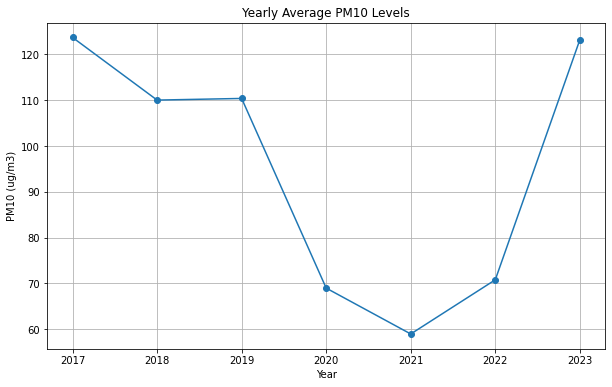

In [38]:
import matplotlib.pyplot as plt

# Convert to Pandas DataFrame for easy plotting
pandas_yearly_avg = yearly_avg.toPandas()

# Plot Yearly Average PM10 Levels
plt.figure(figsize=(10, 6))
plt.plot(pandas_yearly_avg['year'], pandas_yearly_avg['avg_pm10'], marker='o')
plt.title('Yearly Average PM10 Levels')
plt.xlabel('Year')
plt.ylabel('PM10 (ug/m3)')
plt.grid(True)
plt.show()


In [40]:
# Showing average pollutant levels by state
statewise_avg = df.groupBy("state").agg(
    avg("benzene_ug_m3").alias("avg_benzene"),
    avg("mp_xylene_ug_m3").alias("avg_mp_xylene"),
    avg("co_mg_m3").alias("avg_co"),
    avg("nh3_ug_m3").alias("avg_nh3"),
    avg("so2_ug_m3").alias("avg_so2"),
    avg("eth_benzene_ug_m3").alias("avg_eth_benzene"),
    avg("at_degree_c").alias("avg_at"),
    avg("wd_degree").alias("avg_wd"),
    avg("no_ug_m3").alias("avg_no"),
    avg("toluene_ug_m3").alias("avg_toluene"),
    avg("rh_degree").alias("avg_rh"),
    avg("nox_ug_m3").alias("avg_nox"),
    avg("ozone_ug_m3").alias("avg_ozone"),
    avg("pm10_ug_m3").alias("avg_pm10"),
    avg("ws_m_s").alias("avg_ws"),
    avg("no2_ug_m3").alias("avg_no2"),
    avg("pm2_5_ug_m3").alias("avg_pm2_5")
)

statewise_avg.toPandas()


,state,avg(benzene_ug_m3),avg(mp_xylene_ug_m3),avg(co_mg_m3),avg(nh3_ug_m3),avg(so2_ug_m3),avg(eth_benzene_ug_m3),avg(at_degree_c),avg(wd_degree),avg(no_ug_m3),avg(toluene_ug_m3),avg(rh_degree),avg(nox_ug_m3),avg(ozone_ug_m3),avg(pm10_ug_m3),avg(ws_m_s),avg(no2_ug_m3),avg(pm2_5_ug_m3)
0,Nagaland,0.168188,0.425287,0.335448,2.013861,25.977574,0.383733,18.611982,175.449682,2.167176,0.630000,71.370000,19.730000,9.907606,66.720777,1.098869,2.683215,27.473263
1,Odisha,0.237080,14.017025,1.224452,21.917036,14.937476,52.048672,25.251371,173.515600,13.378198,1.628667,68.320125,23.160833,19.624076,107.241739,2.181547,17.260551,53.395607
2,Mizoram,0.028400,0.129565,0.285552,11.449933,9.939315,0.094180,25.550000,164.895906,4.682817,0.630000,71.370000,19.730000,3.940974,33.917328,1.346724,0.465516,9.506099


In [43]:
# Counting records by AQI Category and state
statewise_aqi_count = df.groupBy("state", "AQI_Category").count().orderBy("state")

# Display the results
statewise_aqi_count.show()


+--------+--------------+-----+
|   state|  AQI_Category|count|
+--------+--------------+-----+
| Mizoram|      Moderate| 5332|
| Mizoram|     Unhealthy|  829|
| Mizoram|          Good|18830|
|Nagaland|      Moderate|10151|
|Nagaland|     Unhealthy| 4650|
|Nagaland|          Good| 6613|
|  Odisha|     Unhealthy|20211|
|  Odisha|      Moderate|24865|
|  Odisha|          Good| 8810|
|  Odisha|Very Unhealthy| 3147|
|  Odisha|     Hazardous| 7373|
+--------+--------------+-----+



In [45]:
# Filtering data for a specific state (e.g., "Delhi")
Odisha_data = df.filter(df.state == "Odisha")

# Show the filtered data
Odisha_data.toPandas()


,benzene_ug_m3,mp_xylene_ug_m3,co_mg_m3,nh3_ug_m3,so2_ug_m3,from_date,eth_benzene_ug_m3,state,at_degree_c,wd_degree,...,to_date,ozone_ug_m3,pm10_ug_m3,ws_m_s,no2_ug_m3,pm2_5_ug_m3,AQI_Category,year,month,week
0,0.00,14.29,2.51,11.85,12.42,2018-02-08 22:00:00,1.95,Odisha,21.35,262.03,...,2018-02-08 23:00:00,7.97,212.88,3.01,27.39,118.77,Hazardous,2018,2,6
1,0.00,0.39,0.91,10.37,43.29,2018-02-21 00:00:00,0.74,Odisha,20.97,216.53,...,2018-02-21 01:00:00,4.98,178.78,2.86,13.62,80.61,Unhealthy,2018,2,8
2,0.00,0.11,1.02,16.69,12.42,2018-02-23 05:00:00,1.52,Odisha,16.96,124.28,...,2018-02-23 06:00:00,25.95,99.06,3.13,15.08,48.41,Moderate,2018,2,8
3,0.00,0.13,1.40,17.22,12.42,2018-02-24 20:00:00,1.54,Odisha,25.29,216.20,...,2018-02-24 21:00:00,7.07,253.45,2.80,35.93,118.62,Hazardous,2018,2,8
4,0.00,14.29,2.62,33.63,12.42,2018-03-21 02:00:00,1.95,Odisha,22.31,116.68,...,2018-03-21 03:00:00,7.35,99.06,3.27,1.60,48.41,Moderate,2018,3,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64401,1.53,1.26,1.51,16.69,3.00,2022-12-04 22:00:00,1.10,Odisha,25.55,7.88,...,2022-12-04 23:00:00,9.34,117.11,0.10,45.63,72.75,Unhealthy,2022,12,48
64402,0.97,1.02,1.47,16.69,3.00,2022-12-05 05:00:00,0.84,Odisha,25.55,7.88,...,2022-12-05 06:00:00,9.10,166.86,0.09,53.48,102.19,Hazardous,2022,12,49
64403,0.79,0.86,1.08,16.69,3.94,2022-12-06 16:00:00,0.77,Odisha,25.55,38.28,...,2022-12-06 17:00:00,10.30,85.96,0.31,55.73,54.79,Moderate,2022,12,49
64404,1.47,1.10,1.19,16.69,2.92,2022-12-12 19:00:00,0.65,Odisha,25.55,8.33,...,2022-12-12 20:00:00,9.42,104.45,0.13,15.08,55.69,Unhealthy,2022,12,50


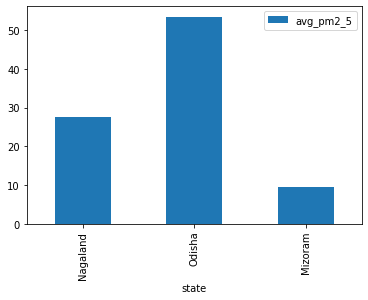

In [46]:
# Collect data to Pandas DataFrame for visualization
import pandas as pd

statewise_avg_pd = statewise_avg.toPandas()

# Now you can use matplotlib or seaborn for visualization
import matplotlib.pyplot as plt

statewise_avg_pd.plot(kind='bar', x='state', y='avg_pm2_5')
plt.show()


<Figure size 720x432 with 0 Axes>

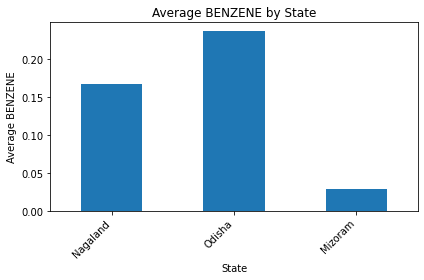

<Figure size 720x432 with 0 Axes>

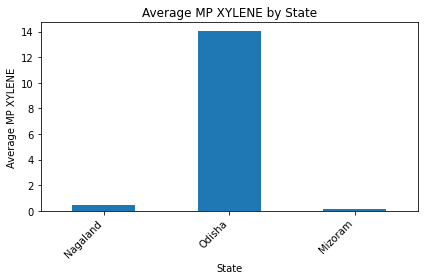

<Figure size 720x432 with 0 Axes>

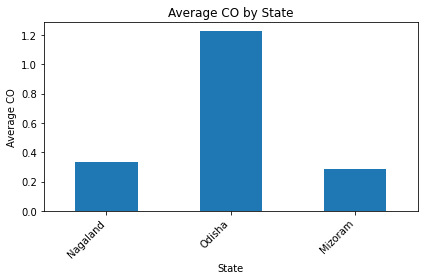

<Figure size 720x432 with 0 Axes>

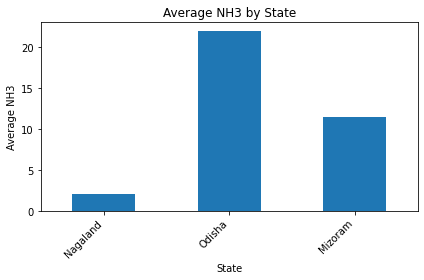

<Figure size 720x432 with 0 Axes>

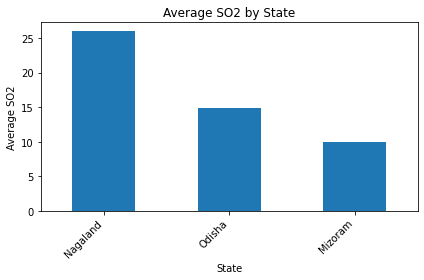

<Figure size 720x432 with 0 Axes>

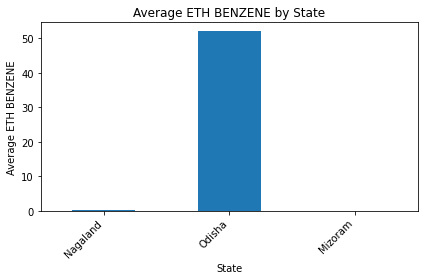

<Figure size 720x432 with 0 Axes>

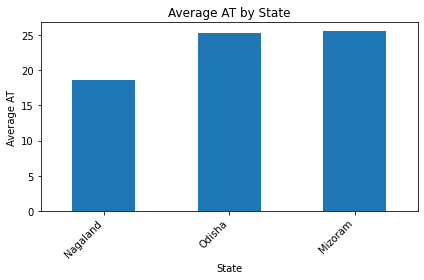

<Figure size 720x432 with 0 Axes>

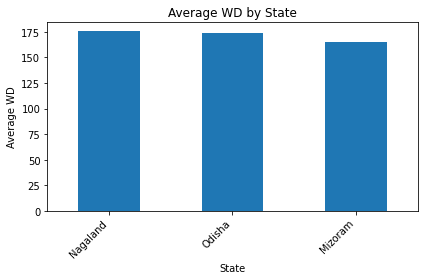

<Figure size 720x432 with 0 Axes>

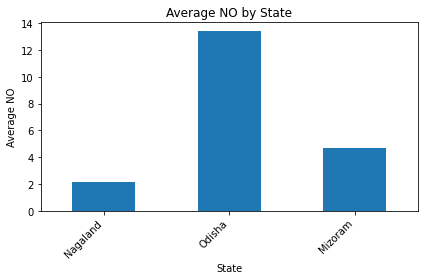

<Figure size 720x432 with 0 Axes>

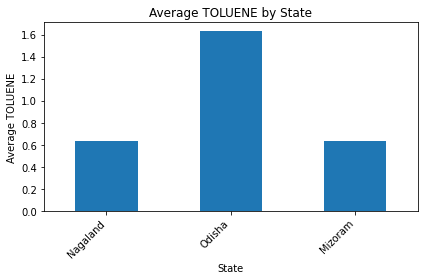

<Figure size 720x432 with 0 Axes>

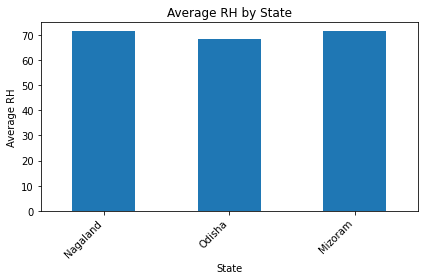

<Figure size 720x432 with 0 Axes>

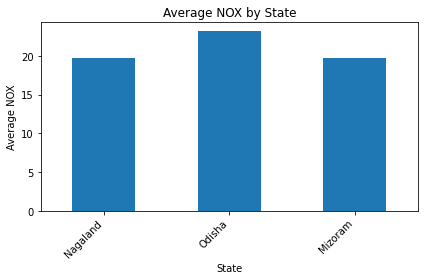

<Figure size 720x432 with 0 Axes>

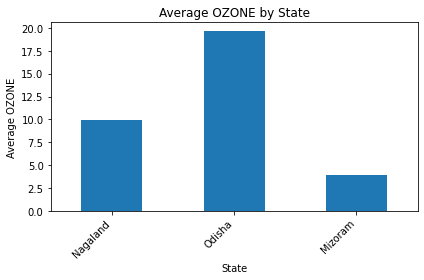

<Figure size 720x432 with 0 Axes>

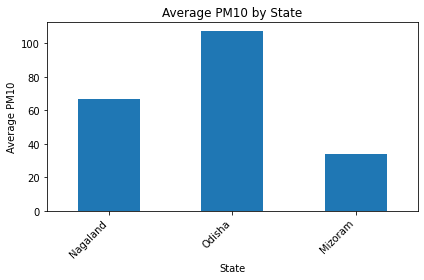

<Figure size 720x432 with 0 Axes>

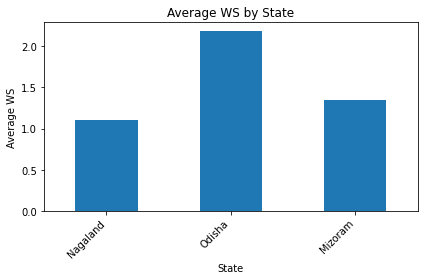

<Figure size 720x432 with 0 Axes>

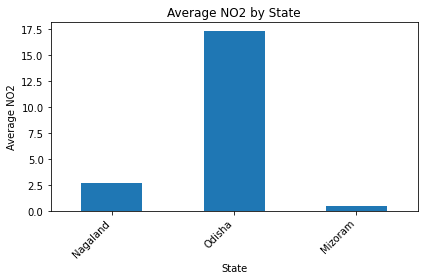

<Figure size 720x432 with 0 Axes>

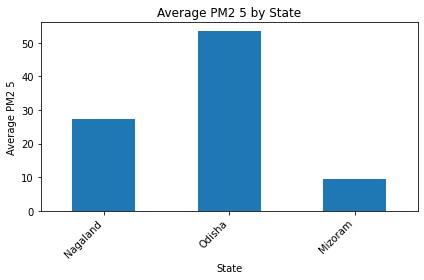

In [47]:
# Importing required libraries
import pandas as pd
import matplotlib.pyplot as plt

# Assuming statewise_avg is your DataFrame with average pollutant values by state
statewise_avg_pd = statewise_avg.toPandas()

# List of pollutants to plot
pollutants = [
    "avg_benzene", 
    "avg_mp_xylene", 
    "avg_co", 
    "avg_nh3", 
    "avg_so2", 
    "avg_eth_benzene", 
    "avg_at", 
    "avg_wd", 
    "avg_no", 
    "avg_toluene", 
    "avg_rh", 
    "avg_nox", 
    "avg_ozone", 
    "avg_pm10", 
    "avg_ws", 
    "avg_no2", 
    "avg_pm2_5"
]

# Iterating over each pollutant to create bar plots
for pollutant in pollutants:
    plt.figure(figsize=(10, 6))
    statewise_avg_pd.plot(kind='bar', x='state', y=pollutant, legend=False)
    plt.title(f'Average {pollutant.replace("avg_", "").replace("_", " ").upper()} by State')
    plt.ylabel(f'Average {pollutant.replace("avg_", "").replace("_", " ").upper()}')
    plt.xlabel('State')
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()
